<a href="https://colab.research.google.com/github/w4bo/2022-bbs-dm/blob/main/notebooks/03-Housing-MachineLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Scikit-learn, Machine Learning in Python
- Simple and efficient tools for predictive data analysis
- Accessible to everybody, and reusable in various contexts
- Built on NumPy, SciPy, and matplotlib
- Open source, commercially usable - BSD license


Check also: 
- https://scikit-learn.org/stable/index.html
- https://scikit-learn.org/stable/modules/tree.html

In case you need help with preprocessing, check:
- https://github.com/w4bo/2022-bbs-dm/blob/main/notebooks/02-Housing-DataPreprocessing.ipynb

In [ ]:
!pip install paretoset 

from paretoset import paretoset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import seaborn as sns
np.random.seed(42)  # why are we fixing the seed?

Solution of the previous `Hands on`

In [ ]:
def preprocess(normalize=True):
    # df = pd.read_csv("datasets/housing.csv", delimiter=",")
    df = pd.read_csv("https://raw.githubusercontent.com/w4bo/2022-bbs-dm/main/notebooks/datasets/housing.csv", delimiter=",")

    num_df = df.drop(columns=["ocean_proximity", "median_house_value"])

    # Filling in (i.e., impute) missing values with the median value 
    num_df["total_bedrooms"] = num_df["total_bedrooms"].fillna(num_df["total_bedrooms"].median())

    # Add a new column: population_per_household = population / households
    num_df["population_per_household"] = num_df["population"] / num_df["households"]

    # Add a new column: rooms_per_household = total_rooms / households
    num_df["rooms_per_household"] = num_df["total_rooms"] / num_df["households"]

    # Add a new column: bedrooms_per_room = total_bedrooms / total_rooms
    num_df["bedrooms_per_room"] = num_df["total_bedrooms"] / num_df["total_rooms"]

    if normalize:
        # Apply standardization to all the numeric columns
        num_df = (num_df - num_df.mean()) / num_df.std()

    # One hot encode `ocean_proximity` since it is a categorical attribute 
    cat_df = pd.get_dummies(df["ocean_proximity"], prefix='ocean_proximity')

    # Join all the dataframes
    return pd.concat([num_df, cat_df, df[["median_house_value"]]], axis=1) # do not change this line

df = preprocess(False)
df

In [ ]:
tmp = df[["population_per_household", "rooms_per_household", "bedrooms_per_room", "median_house_value"]]
sns.pairplot(tmp.sample(n=1000, random_state=42), markers='+')
plt.show()

Before delving into machine learning, which are the houses the represent a good tradeof between cost and number of rooms?

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1)
df.plot.scatter(x='median_house_value', y='total_bedrooms', ax=ax)

In [ ]:
mask = paretoset(df[["median_house_value", "total_bedrooms"]], sense=["min", "max"])
df[mask].plot.scatter(x='median_house_value', y='total_bedrooms', ax=ax, c='red')
fig

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1)
df.plot.scatter(x="housing_median_age", y="total_bedrooms", c="median_house_value", ax=ax)

In [ ]:
mask = paretoset(df[["housing_median_age", "total_bedrooms", "median_house_value"]], sense=["min", "max", "min"])
df[mask].plot.scatter(x="housing_median_age", y="total_bedrooms", ax=ax, c='red')
fig

For a supervised learning problem we need:
- input data along with labels
- split data between test and training set. How?

In [ ]:
# For illustration only. Sklearn has train_test_split()
def split_train_test(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data)) # get a list of random numbers
    test_set_size = int(len(data) * test_ratio) # define the size of test dataset
    test_indices = shuffled_indices[:test_set_size] # the test dataset includes some indexes 
    train_indices = shuffled_indices[test_set_size:] # the train dataset includes the others (no overlapping)
    return data.iloc[train_indices], data.iloc[test_indices] # return the two dataframes

df = preprocess(True)
df_train, df_test = split_train_test(df, 0.2) # get the train and test dataframes

X_train = df_train.drop(columns=["median_house_value"]).to_numpy() # get the train feature matrix
X_test  = df_test.drop(columns=["median_house_value"]).to_numpy() # get the test feature matrix
y_train = df_train["median_house_value"].to_numpy() # get the train label array
y_test  = df_test["median_house_value"].to_numpy() # get the test label array

In [ ]:
from sklearn.model_selection import train_test_split
y = df["median_house_value"] # labels
X = df.drop(columns=["median_house_value"]) # input data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [ ]:
X_train

In [ ]:
y_train

Apply linear regression to forecast housing values

https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html

"LinearRegression fits a linear model with coefficients w = (w1, …, wp) to minimize the residual sum of squares between the observed targets in the dataset, and the targets predicted by the linear approximation."

In [ ]:
from sklearn.linear_model import LinearRegression # import the model

lin_reg = LinearRegression() # initialize the model (i.e., the estimator)
lin_reg.fit(X_train, y_train) # train it
housing_predictions = lin_reg.predict(X_test) # predict the cost of houses in the test set

lin_mse = mean_squared_error(y_test, housing_predictions) # check the error
lin_rmse = np.sqrt(lin_mse) # apply the squared root of the error
print(lin_rmse) # print it

# visualize some predictions
df = pd.DataFrame({'y_test': y_test[:10].to_numpy(), 'y_pred': housing_predictions[:10]}, index=[x for x in range(10)])
df.plot.bar(rot=0)

This is better than nothing, but clearly not a great score: most districts’ `median_housing_values` range between 120K USD and  265K USD, so a typical prediction error of ~70K USD is not very satisfying. This is an example of a model underfitting the training data.

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html

"A random forest is a meta estimator that fits a number of classifying decision trees on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting. The sub-sample size is controlled with the max_samples parameter if bootstrap=True (default), otherwise the whole dataset is used to build each tree."

In [ ]:
from sklearn.ensemble import RandomForestRegressor # import the model

def run_forest(n_estimators, max_features):
    # initialize the model (i.e., the estimator)
    forest_reg = RandomForestRegressor(n_estimators=n_estimators, max_features=max_features, random_state=42)
    forest_reg.fit(X_train, y_train) # train it
    housing_predictions = forest_reg.predict(X_test) # predict the cost of houses in the test set
    
    forest_rmse = mean_squared_error(y_test, housing_predictions, squared=True) # check the error
    forest_rmse = np.sqrt(forest_rmse) # apply the squared root of the error
    print(forest_rmse)
    
    df = pd.DataFrame({'y_test': y_test[:10].to_numpy(), 'y_pred': housing_predictions[:10]}, index=[x for x in range(10)])
    df.plot.bar(rot=0)
    return forest_reg

forest_reg = run_forest(100, "auto")

Look at parameters used by our current forest

In [ ]:
forest_reg.get_params()

https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html
    
"The parameters of the estimator used to apply these methods are optimized by cross-validated search over parameter settings. In contrast to GridSearchCV, not all parameter values are tried out, but rather a fixed number of parameter settings is sampled from the specified distributions. The number of parameter settings that are tried is given by `n_iter`."

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

n_estimators = [50, 100, 150]  # Number of trees in random forest
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# auto -> n_features
# sqrt -> max_features=sqrt(n_features)
random_grid = {'n_estimators': n_estimators, 'max_features': max_features}

# Fit the random search model
rf_random = RandomizedSearchCV(estimator=forest_reg, param_distributions=random_grid, cv=3, verbose=2, random_state=42)
rf_random.fit(X_train, y_train)
rf_random.best_params_

In [ ]:
run_forest(150, "sqrt")

#### Dimensionality reduction

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
result = pca.fit_transform(X_train.values)

plt.scatter(
    x=result[:,0], 
    y=result[:,1] , 
    c=y_train,
    cmap='viridis'
)

In [ ]:
# Dump components relations with features
pd.DataFrame(pca.components_, columns=X_train.columns, index=['PC1', 'PC2'])

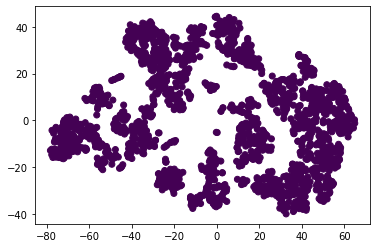

In [78]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2)
result = tsne.fit_transform(X_train.head(2000))

plt.scatter(
    x=result[:,0], 
    y=result[:,1] , 
    c=y_train.head(2000).apply(lambda x: 0 if x == 'low' else (1 if x == 'medium' else 2)), 
    cmap='viridis'
)

#### Classification

- Create classes (low, medium, high) from the target value
- Create and fit a decision tree

In [ ]:
df = preprocess(False) # clean the dataset withtout standardization
bins = ["low", "medium", "high"] # the labels we are gonna use
df["median_house_value"] = pd.cut(df["median_house_value"], 3, labels=bins) # map bins of values into labels
df["median_house_value"].hist() # plot them

For the sake of performance, we are going to use a manually defined set of features

In [ ]:
y = df["median_house_value"] # labels
X = df[["latitude", "longitude", "median_income", "population", "households", "total_bedrooms"]] # consider only some features from the train dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42) # split the dataset

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn import tree

clf = tree.DecisionTreeClassifier(criterion="entropy", random_state=42) # initialize the model
clf = clf.fit(X_train, y_train) # train it
housing_predictions = clf.predict(X_test) # predict the cost of houses in the test set

accuracy = accuracy_score(y_test, housing_predictions) # check the error
accuracy

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, housing_predictions, target_names=bins))

In [ ]:
plt.figure(figsize=(20,12))
tree.plot_tree(clf, fontsize=10, feature_names=X_train.columns, class_names=bins, max_depth=4)
plt.show()

In [ ]:
from sklearn.ensemble import RandomForestClassifier

forest_cls = RandomForestClassifier(criterion="entropy", random_state=42) # initialize the model
forest_cls = forest_cls.fit(X_train, y_train) # train it
housing_predictions = forest_cls.predict(X_test) # predict the cost of houses in the test set

accuracy = accuracy_score(y_test, housing_predictions) # check the error
accuracy

In [ ]:
forest_cls.get_params()

In [ ]:
n_estimators = [50, 100, 150]  # Number of trees in random forest
max_features = ['auto', 'sqrt'] # Number of features to consider at every split
min_samples_leaf = [1, 5]
max_depth = [2, 5]
random_grid = {'n_estimators': n_estimators, 'max_features': max_features, 'min_samples_leaf': min_samples_leaf, 'max_depth': max_depth}

# Fit the random search model
rf_random = RandomizedSearchCV(estimator=forest_cls, param_distributions=random_grid, cv=3, verbose=2, random_state=42)
rf_random.fit(X_train, y_train)
rf_random.best_params_

In [ ]:
forest_cls = RandomForestClassifier(criterion="gini", random_state=42, n_estimators=50, max_features="sqrt", min_samples_leaf=1, max_depth=5) 
forest_cls = forest_cls.fit(X_train, y_train) # train it
housing_predictions = forest_cls.predict(X_test) # predict the cost of houses in the test set

accuracy = accuracy_score(y_test, housing_predictions) # check the error
accuracy

In [ ]:
forest_cls.get_params()